## Analyzing Odds Data
- In the last notebook / lesson we obtained historical odds data from oddsshark, and then augmented our game level data to include the implied probabilities, and over/under lines.
- We saved that data to a file called 'df_bp3.csv'
- In this notebook, we will do some initial exploration of that odds data, and compare the quality of our first model predictions to the implied probabilities given by the oddsmakers.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgbm
import structureboost as stb
import ml_insights as mli
from structureboost import log_loss
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

In [2]:
df=pd.read_csv('df_bp3.csv')

/var/folders/9d/8vjj2hs92bq3s8th__4v3jfh0000gn/T/ipykernel_64292/438026221.py:1: DtypeWarning: Columns (13,14,15,85,87,198) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('df_bp3.csv')


## Data Checks / Exploration

In [3]:
df.info(max_cols=1000)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73507 entries, 0 to 73506
Data columns (total 199 columns):
 #    Column                Non-Null Count  Dtype  
---   ------                --------------  -----  
 0    date                  73507 non-null  int64  
 1    dblheader_code        73507 non-null  int64  
 2    day_of_week           73507 non-null  object 
 3    team_v                73507 non-null  object 
 4    league_v              73507 non-null  object 
 5    game_no_v             73507 non-null  int64  
 6    team_h                73507 non-null  object 
 7    league_h              73507 non-null  object 
 8    game_no_h             73507 non-null  int64  
 9    runs_v                73507 non-null  int64  
 10   runs_h                73507 non-null  int64  
 11   outs_total            73507 non-null  int64  
 12   day_night             73507 non-null  object 
 13   completion_info       49 non-null     object 
 14   forfeit_info          1 non-null      object 
 15   

In [4]:
pd.crosstab(df.implied_prob_h>0, df.season)

season,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2020,2021,2022
implied_prob_h,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,2105,2104,2106,2269,1600,2017,2267,2266,2432,2428,2429,2429,2426,2430,2428,2431,2429,2431,2428,2430,2430,2429,2430,2431,2430,2429,2428,2430,2431,0,0,0
True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,898,2426,2430


In [5]:
df_odds = df[df.season>=2019]

In [6]:
df_odds.sample(5)

,date,dblheader_code,day_of_week,team_v,league_v,game_no_v,team_h,league_h,game_no_h,runs_v,runs_h,outs_total,day_night,completion_info,forfeit_info,protest_info,ballpark_id,attendance,game_minutes,linescore_v,linescore_h,AB_v,H_v,2B_v,3B_v,HR_v,RBI_v,SH_v,SF_v,HBP_v,BB_v,IBB_v,SO_v,SB_v,CS_v,GIDP_v,CI_v,LOB_v,P_num_v,ERind_v,ERteam_v,WP_v,balk_v,PO_v,ASST_v,ERR_v,PB_v,DP_v,TP_v,AB_h,H_h,2B_h,3B_h,HR_h,RBI_h,SH_h,SF_h,HBP_h,BB_h,IBB_h,SO_h,SB_h,CS_h,GIDP_h,CI_h,LOB_h,P_num_h,ERind_h,ERteam_h,WP_h,balk_h,PO_h,ASST_h,ERR_h,PB_h,DP_h,TP_h,ump_HB_id,ump_HB_name,ump_1B_id,ump_1B_name,ump_2B_id,ump_2B_name,ump_3B_id,ump_3B_name,ump_LF_id,ump_LF_name,ump_RF_id,ump_RF_name,mgr_id_v,mgr_name_v,mgr_id_h,mgr_name_h,pitcher_id_w,pitcher_name_w,pitcher_id_l,pitcher_name_l,pitcher_id_s,pitcher_name_s,GWRBI_id,GWRBI_name,pitcher_start_id_v,pitcher_start_name_v,pitcher_start_id_h,pitcher_start_name_h,batter1_name_v,batter1_id_v,batter1_pos_v,batter2_name_v,batter2_id_v,batter2_pos_v,batter3_name_v,batter3_id_v,batter3_pos_v,batter4_name_v,batter4_id_v,batter4_pos_v,batter5_name_v,batter5_id_v,batter5_pos_v,batter6_name_v,batter6_id_v,batter6_pos_v,batter7_name_v,batter7_id_v,batter7_pos_v,batter8_name_v,batter8_id_v,batter8_pos_v,batter9_name_v,batter9_id_v,batter9_pos_v,batter1_name_h,batter1_id_h,batter1_pos_h,batter2_name_h,batter2_id_h,batter2_pos_h,batter3_name_h,batter3_id_h,batter3_pos_h,batter4_name_h,batter4_id_h,batter4_pos_h,batter5_name_h,batter5_id_h,batter5_pos_h,batter6_name_h,batter6_id_h,batter6_pos_h,batter7_name_h,batter7_id_h,batter7_pos_h,batter8_name_h,batter8_id_h,batter8_pos_h,batter9_name_h,batter9_id_h,batter9_pos_h,misc_info,acqui_info,season,run_diff,home_victory,run_total,date_dblhead,BATAVG_162_h,BATAVG_162_v,OBP_162_h,OBP_162_v,SLG_162_h,SLG_162_v,OBS_162_h,OBS_162_v,SB_162_h,SB_162_v,CS_162_h,CS_162_v,ERR_162_h,ERR_162_v,BATAVG_30_h,BATAVG_30_v,OBP_30_h,OBP_30_v,SLG_30_h,SLG_30_v,OBS_30_h,OBS_30_v,SB_30_h,SB_30_v,CS_30_h,CS_30_v,ERR_30_h,ERR_30_v,implied_prob_h,implied_prob_v,implied_prob_h_mid,over_under_line,over_under_result
70852,20210917,0,Fri,SEA,AL,147,KCA,AL,147,6,2,54,N,NaN,NaN,NaN,KAN06,14904.0,215,020200110,000001100,33,10,1,0,2,6,0,0,1,4,0,7,0,1,2,0,5,5,2,2,1,0,27,7,0,0,2,0,34,9,1,0,1,2,0,0,1,4,0,5,0,0,1,0,10,6,6,6,0,0,27,14,0,0,3,0,lives901,Shane Livensparger,holbs901,Sam Holbrook,viscj901,Jansen Visconti,wolfj901,Jim Wolf,NaN,(none),NaN,(none),servs002,Scott Servais,mathm001,Mike Matheny,flexc001,Chris Flexen,heasj001,Jon Heasley,NaN,(none),kelej001,Jarred Kelenic,flexc001,Chris Flexen,heasj001,Jon Heasley,crawj002,J.P. Crawford,6,hanim001,Mitch Haniger,9,seagk001,Kyle Seager,5,frant002,Ty France,3,toroa001,Abraham Toro,4,kelej001,Jarred Kelenic,8,torrl001,Luis Torrens,10,fralj001,Jake Fraley,7,ralec001,Cal Raleigh,2,merrw001,Whit Merrifield,4,lopen001,Nicky Lopez,6,peres002,Salvador Perez,2,benia002,Andrew Benintendi,7,santc002,Carlos Santana,10,taylm002,Michael Taylor,8,dozih001,Hunter Dozier,3,isbek001,Kyle Isbel,9,albeh001,Hanser Alberto,5,NaN,Y,2021,-4,0,8,202109170,0.248162,0.222786,0.303711,0.294298,0.397426,0.377327,0.701138,0.671625,131.0,68.0,33.0,26.0,80.0,78.0,0.269991,0.227580,0.318701,0.301047,0.427093,0.380906,0.745794,0.681954,31.0,11.0,8.0,6.0,12.0,17.0,0.500000,0.523810,0.488095,9.0,U
70197,20210730,0,Fri,CLE,AL,100,CHA,AL,104,4,6,51,N,NaN,NaN,NaN,CHI12,36123.0,222,200010010,01021002x,34,9,1,0,1,4,1,0,1,3,0,12,1,0,0,0,8,6,6,6,0,0,24,9,2,1,0,0,34,11,0,0,1,6,0,0,2,6,0,9,0,0,0,0,12,6,4,4,0,0,27,7,0,1,0,0,mosce901,Edwin Moscoso,muchm901,Mike Muchlinski,holbs901,Sam Holbrook,wolfj901,Jim Wolf,NaN,(none),NaN,(none),haled801,DeMarlo Hale,larut101,Tony LaRussa,ruizj001,Jose Ruiz,karij001,James Karinchak,hendl001,Liam Hendriks,andet001,Tim Anderson,mejij002,Jean Carlos Mejia,lynnl001,Lance Lynn,zimmb001,Bradley Zimmer,8,rosaa003,Amed Rosario,6,ramij003,Jose Ramirez,5,reyef001,Franmil Reyes,10,ramih004,Harold Ramirez,7,johnd006,Daniel Johnson,9,perer003,Roberto Perez,2,chany001,Yu Chang,3,

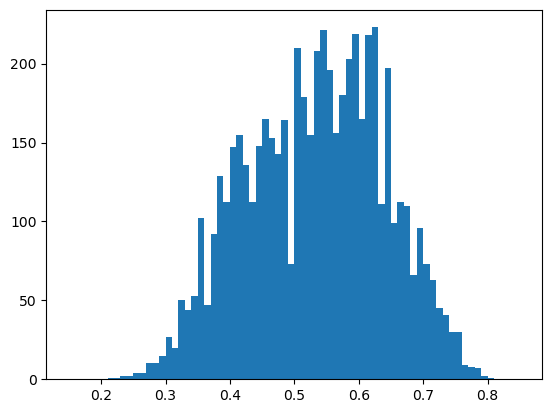

In [7]:
plt.hist(df_odds.implied_prob_h_mid, bins=np.linspace(.15,.85,71));

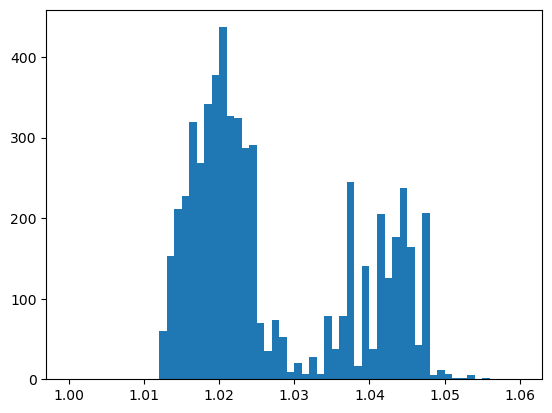

In [8]:
plt.hist(df_odds.implied_prob_h + df_odds.implied_prob_v, bins=np.linspace(1,1.06,61));

## Begin Modeling

In [9]:
df = df[df.run_diff!=0]
df_train = df[(df.season>1980) & (df.season<=2018)]
df_valid = df[(df.season>=2019) & (df.season<=2020)]
df_test = df[df.season>=2021]

In [10]:
features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            # 'OBP_30_h','OBP_30_v',
            # 'SLG_30_h','SLG_30_v',
            # 'game_no_h',
           ]
target = 'home_victory'

In [11]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [12]:
X_train.shape, X_valid.shape, X_test.shape, 

((67740, 4), (898, 4), (4856, 4))

In [13]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=3)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

[LightGBM] [Info] Number of positive: 36446, number of negative: 31294
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 67740, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.538028 -> initscore=0.152405
[LightGBM] [Info] Start training from score 0.152405
Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.686722
[20]	valid_0's binary_logloss: 0.686343
[30]	valid_0's binary_logloss: 0.686219
[40]	valid_0's binary_logloss: 0.686176
[50]	valid_0's binary_logloss: 0.686169
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	valid_0's binary_l

LGBMClassifier(learning_rate=0.02, max_depth=3, n_estimators=1000)

In [14]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [15]:
hv_mean = y_train.mean()

In [16]:
lgbm_loss = log_loss(y_test, preds_lgbm)
naive_loss = log_loss(y_test, hv_mean*np.ones(len(y_test)))
lgbm_loss, naive_loss

(0.6854701750127649, 0.6904926614038469)

In [17]:
lv_loss = log_loss(y_test, df_test.implied_prob_h_mid)
lv_loss

0.6674197609198098

In [18]:
(naive_loss - lgbm_loss)/(naive_loss - lv_loss)

0.2176790210904276

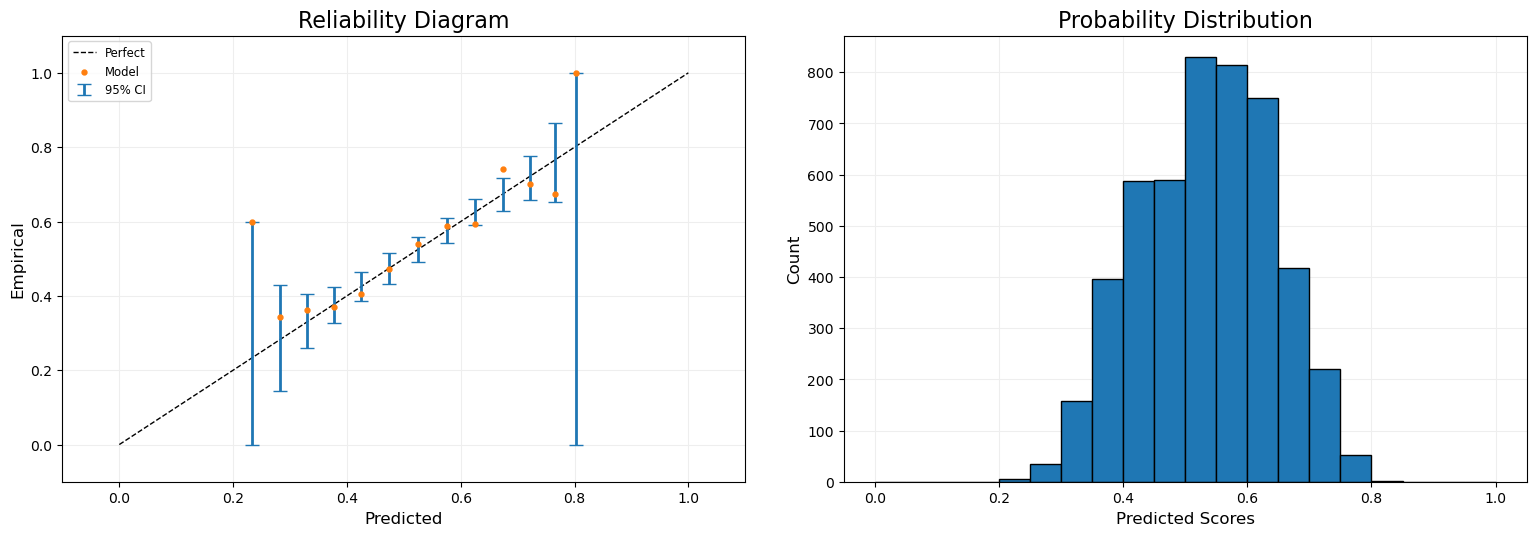

In [19]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, df_test.implied_prob_h_mid, show_histogram=True);

## Analyze discrepancies

In [20]:
test_disc = np.abs(preds_lgbm - df_test.implied_prob_h_mid)

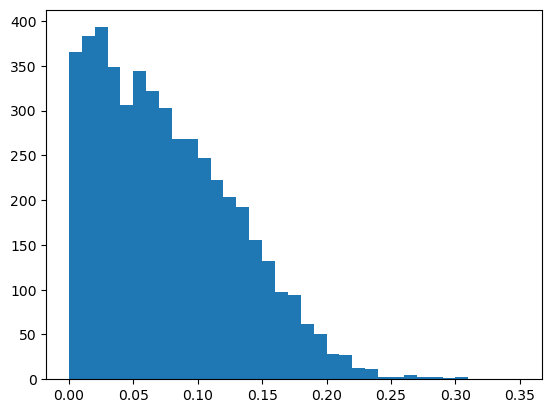

In [21]:
plt.hist(test_disc, np.linspace(0,.35,36));

In [22]:
df_test[test_disc>.25]

,date,dblheader_code,day_of_week,team_v,league_v,game_no_v,team_h,league_h,game_no_h,runs_v,runs_h,outs_total,day_night,completion_info,forfeit_info,protest_info,ballpark_id,attendance,game_minutes,linescore_v,linescore_h,AB_v,H_v,2B_v,3B_v,HR_v,RBI_v,SH_v,SF_v,HBP_v,BB_v,IBB_v,SO_v,SB_v,CS_v,GIDP_v,CI_v,LOB_v,P_num_v,ERind_v,ERteam_v,WP_v,balk_v,PO_v,ASST_v,ERR_v,PB_v,DP_v,TP_v,AB_h,H_h,2B_h,3B_h,HR_h,RBI_h,SH_h,SF_h,HBP_h,BB_h,IBB_h,SO_h,SB_h,CS_h,GIDP_h,CI_h,LOB_h,P_num_h,ERind_h,ERteam_h,WP_h,balk_h,PO_h,ASST_h,ERR_h,PB_h,DP_h,TP_h,ump_HB_id,ump_HB_name,ump_1B_id,ump_1B_name,ump_2B_id,ump_2B_name,ump_3B_id,ump_3B_name,ump_LF_id,ump_LF_name,ump_RF_id,ump_RF_name,mgr_id_v,mgr_name_v,mgr_id_h,mgr_name_h,pitcher_id_w,pitcher_name_w,pitcher_id_l,pitcher_name_l,pitcher_id_s,pitcher_name_s,GWRBI_id,GWRBI_name,pitcher_start_id_v,pitcher_start_name_v,pitcher_start_id_h,pitcher_start_name_h,batter1_name_v,batter1_id_v,batter1_pos_v,batter2_name_v,batter2_id_v,batter2_pos_v,batter3_name_v,batter3_id_v,batter3_pos_v,batter4_name_v,batter4_id_v,batter4_pos_v,batter5_name_v,batter5_id_v,batter5_pos_v,batter6_name_v,batter6_id_v,batter6_pos_v,batter7_name_v,batter7_id_v,batter7_pos_v,batter8_name_v,batter8_id_v,batter8_pos_v,batter9_name_v,batter9_id_v,batter9_pos_v,batter1_name_h,batter1_id_h,batter1_pos_h,batter2_name_h,batter2_id_h,batter2_pos_h,batter3_name_h,batter3_id_h,batter3_pos_h,batter4_name_h,batter4_id_h,batter4_pos_h,batter5_name_h,batter5_id_h,batter5_pos_h,batter6_name_h,batter6_id_h,batter6_pos_h,batter7_name_h,batter7_id_h,batter7_pos_h,batter8_name_h,batter8_id_h,batter8_pos_h,batter9_name_h,batter9_id_h,batter9_pos_h,misc_info,acqui_info,season,run_diff,home_victory,run_total,date_dblhead,BATAVG_162_h,BATAVG_162_v,OBP_162_h,OBP_162_v,SLG_162_h,SLG_162_v,OBS_162_h,OBS_162_v,SB_162_h,SB_162_v,CS_162_h,CS_162_v,ERR_162_h,ERR_162_v,BATAVG_30_h,BATAVG_30_v,OBP_30_h,OBP_30_v,SLG_30_h,SLG_30_v,OBS_30_h,OBS_30_v,SB_30_h,SB_30_v,CS_30_h,CS_30_v,ERR_30_h,ERR_30_v,implied_prob_h,implied_prob_v,implied_prob_h_mid,over_under_line,over_under_result
70636,20210901,0,Wed,NYA,AL,133,ANA,AL,134,4,1,54,D,NaN,NaN,NaN,ANA01,28753.0,170,002100010,000001000,33,8,1,0,1,4,0,0,1,3,0,7,0,1,1,0,6,3,1,1,0,0,27,8,0,0,0,0,31,4,2,0,0,1,0,0,0,0,0,16,0,0,0,0,3,5,4,4,0,0,27,13,0,0,2,0,valej901,Junior Valentine,holbs901,Sam Holbrook,muchm901,Mike Muchlinski,wolfj901,Jim Wolf,NaN,(none),NaN,(none),boona001,Aaron Boone,maddj801,Joe Maddon,coleg001,Gerrit Cole,naugp001,Packy Naughton,chapa001,Aroldis Chapman,voitl001,Luke Voit,coleg001,Gerrit Cole,naugp001,Packy Naughton,lemad001,DJ LeMahieu,4,rizza001,Anthony Rizzo,3,judga001,Aaron Judge,9,voitl001,Luke Voit,10,gallj002,Joey Gallo,7,higak001,Kyle Higashioka,2,odorr001,Rougned Odor,5,velaa001,Andrew Velazquez,6,gardb001,Brett Gardner,8,fletd002,David Fletcher,4,ohtas001,Shohei Ohtani,10,gossp001,Phil Gosselin,5,walsj001,Jared Walsh,3,uptoj001,Justin Upton,7,marsb002,Brandon Marsh,8,stasm001,Max Stassi,2,adelj001,Jo Adell,9,mayfj001,Jack Mayfield,6,NaN,Y,2021,-3,0,5,202109010,0.253074,0.240195,0.314006,0.325054,0.424482,0.409645,0.738488,0.734700,75.0,70.0,27.0,17.0,94.0,110.0,0.226950,0.250501,0.292208,0.329148,0.355623,0.434870,0.647831,0.764018,23.0,20.0,8.0,4.0,11.0,20.0,0.294118,0.736842,0.278638,8.5,U
70810,20210914,0,Tue,NYA,AL,145,BAL,AL,144,7,2,54,N,NaN,NaN,NaN,BAL12,10235.0,208,203000011,000010001,37,13,0,0,5,7,0,0,1,3,0,4,1,0,3,0,7,4,2,2,1,0,27,3,1,0,1,0,33,6,2,0,0,2,0,0,0,5,0,12,0,0,1,0,9,4,7,7,0,0,27,10,1,0,3,0,timmt901,Tim Timmons,addir901,Ryan Additon,torrc901,Carlos Torres,barrl901,Lance Barrett,NaN,(none),NaN,(none),boona001,Aaron Boone,hydeb801,Brandon Hyde,coleg001,Gerrit Cole,wella001,Alexander Wells,NaN,(none),judga001,Aaron Judge,coleg001,Gerrit Cole,wella001,Alexander Wells,lemad001,DJ LeMahieu,5,judga001,Aaron Judge,8,rizza001,Anthony Rizzo,3,stanm004,Giancarlo Stanton,7,voitl001,Luke Voit,10,gallj002,Joey Gallo,9,torrg001,Gleyber Torres,4,urshg001,Giovanny Urshela,6,higak001,Kyle Hi

In [23]:
# These are the pitchers that were favored in these games
[row[1]['pitcher_start_name_h']  if row[1]['implied_prob_h_mid']>.5 
 else row[1]['pitcher_start_name_v'] 
 for row in df_test[test_disc>.25].iterrows() ]

['Gerrit Cole',
 'Gerrit Cole',
 'Max Fried',
 'Max Fried',
 'Spencer Strider',
 'Jacob deGrom',
 'Chris Bassitt',
 'Mike Clevinger',
 'Yu Darvish',
 'Blake Snell',
 'Yu Darvish',
 'Jacob deGrom',
 'Jacob deGrom',
 'Jacob deGrom',
 'Max Scherzer']

In [24]:
# These are the underdog pitchers in these games
[row[1]['pitcher_start_name_h']  if row[1]['implied_prob_h_mid']<.5 
 else row[1]['pitcher_start_name_v'] for row in df_test[test_disc>.25].iterrows() ]

['Packy Naughton',
 'Alexander Wells',
 'Jackson Tetreault',
 'Mike Minor',
 'Erasmo Ramirez',
 'Cory Abbott',
 'Anibal Sanchez',
 'Cory Abbott',
 'Anibal Sanchez',
 'Paolo Espino',
 'Anibal Sanchez',
 'Ryan Feltner',
 'Johan Oviedo',
 'Ken Waldichuk',
 'JP Sears']

In [25]:
pd.crosstab(df_test.home_victory[test_disc>.2], 
            np.round(df_test.implied_prob_h_mid[test_disc>.2], decimals=1))

implied_prob_h_mid,0.2,0.3,0.4,0.7,0.8
home_victory,,,,,
0,2,38,1,2,9
1,3,19,1,12,11


In [26]:
pd.crosstab(df_test.home_victory[test_disc>.2], 
            np.round(preds_lgbm[test_disc>.2], decimals=1))

col_0,0.5,0.6
home_victory,,
0,45,7
1,36,10


## Analysis
- LV odds are "better" than our current model
- Largest discrepancies appear when we have a strong pitcher vs a weak pitcher
- LV probs seem to be "right" in those cases
- CONCLUSION: Need to factor in the starting pitcher to improve our model!

## Approach
- Get game level data for each pitcher
- Compute statistics based on recent performance of that pitcher
- Augment main dataframe to include these statistics for each game (as would be known prior to the game)
- Build model with these additional features